In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from IPython.display import display

from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [2]:
def load_data():
    #Read the data
    df_train = pd.read_csv("/kaggle/input/playground-series-s3e9/train.csv", index_col="id")
    df_test = pd.read_csv("/kaggle/input/playground-series-s3e9/test.csv", index_col="id")
    df = pd.concat([df_train, df_test])
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test
    


def make_mi_scores(X, y, descrete_features):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [3]:
df_train, df_test = load_data()

<h1>1. EDA</h1>

In [4]:
# Peek at the values
#display(df_train)
#display(df_test)

# Display information about dtypes and missing values
#display(df_train.info())
#display(df_test.info())

array([[<Axes: title={'center': 'CementComponent'}>,
        <Axes: title={'center': 'BlastFurnaceSlag'}>,
        <Axes: title={'center': 'FlyAshComponent'}>],
       [<Axes: title={'center': 'WaterComponent'}>,
        <Axes: title={'center': 'SuperplasticizerComponent'}>,
        <Axes: title={'center': 'CoarseAggregateComponent'}>],
       [<Axes: title={'center': 'FineAggregateComponent'}>,
        <Axes: title={'center': 'AgeInDays'}>,
        <Axes: title={'center': 'Strength'}>]], dtype=object)

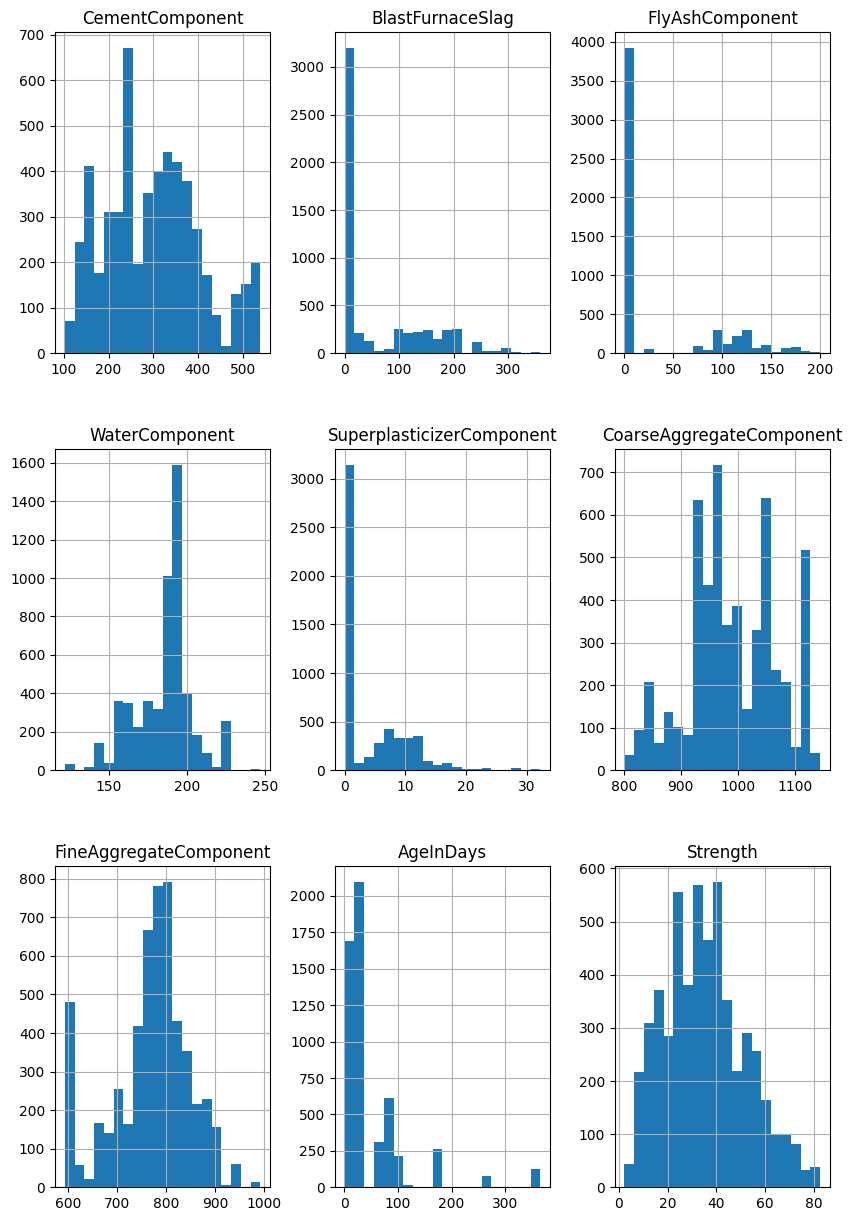

In [5]:
df_train.hist(bins=20, figsize=(10, 15))

<h3>Insight</h3>
<ul>
  <li>Only numeric data columns</li>
  <li>No missing values in the dataset</li>
  <li>Feature distrubution have somewhat different scales and are capped different</li>
</ul>


In [6]:
X = df_train.copy()
y = X.pop("Strength")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.39982 RMSLE


<h1>2.Feature engineering</h1>

<h3>Calculating mutual information scores</h3>

AgeInDays                    0.409958
CementComponent              0.055552
WaterComponent               0.051396
FineAggregateComponent       0.050384
CoarseAggregateComponent     0.050223
BlastFurnaceSlag             0.045691
SuperplasticizerComponent    0.035589
FlyAshComponent              0.014864
Name: MI Scores, dtype: float64


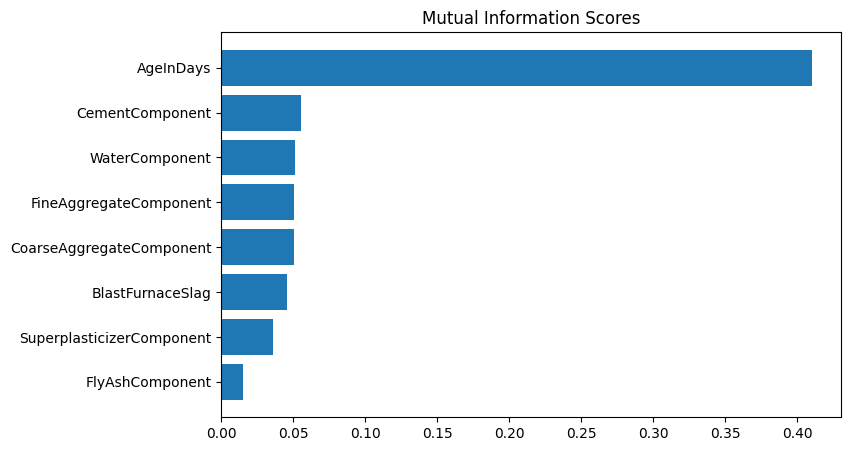

In [7]:
mi_scores = make_mi_scores(X, y, descrete_features=False)
print(mi_scores.head(20))

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

In [8]:
X = df_train.copy()
y = X.pop("Strength")
#Did not improve score at all
#X = X.loc[:, mi_scores > 0.05]

score_dataset(X, y)

0.3998154519369126

<Axes: xlabel='AgeInDays', ylabel='Strength'>

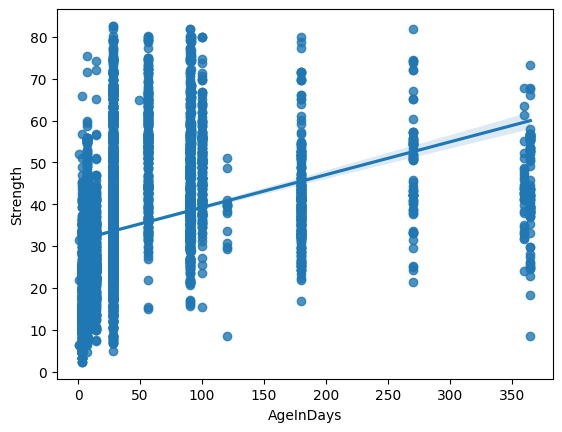

In [9]:
sns.regplot(x="AgeInDays", y="Strength", data=df_train
           )

<h3>Mathematical transforms</h3>

In [10]:
#Experiment with new features
def mathematical_transforms(ds):
    X = pd.DataFrame()
    #X["Water_to_Cement_Ratio"] = ds["WaterComponent"] / ds["CementComponent"]
    X['Fine_to_Coarse_Aggregate_Ratio'] = ds['FineAggregateComponent'] / ds['CoarseAggregateComponent']

    return X

<h3>Apply PCA</h3>

In [11]:
def pca_inspired(ds):
    ds_scaled = (ds - ds.mean(axis=0)) / ds.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(ds_scaled)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)

    return X_pca
    

In [12]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("Strength")
    mi_scores = make_mi_scores(X, y, descrete_features=False)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
         X_test = df_test.copy()
         X_test.pop("Strength")
         X = pd.concat([X, X_test])
     # Lesson 3 - Transformations
    X = X.join(mathematical_transforms(X))

    # Lesson 5 - PCA
    #X = X.join(pca_inspired(X))

    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)
        
    if df_test is not None:
        return X, X_test
    else:
        return X
    

In [13]:
df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train["Strength"]

score_dataset(X_train, y_train)

0.40052811288351314

In [14]:
xgb_params = dict(
    max_depth=6,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)


xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.38348097780960916

<h1>3. Model, predict and solve</h1>

In [15]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train["Strength"]


xgb = XGBRegressor(**xgb_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y))
predictions = np.exp(xgb.predict(X_test))

output = pd.DataFrame({'id': X_test.index, 'Strength': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")



Your submission was successfully saved!
